In [1]:
# !pip install pandas
# !pip install scikit-learn
# !pip install opencv-python-headless

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Dense, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from tensorflow.keras.applications import ResNet50, EfficientNetB0
import cv2
import matplotlib.pyplot as plt


In [3]:
import GPUtil
import tensorflow as tf
import platform
import psutil
import sys
import pkg_resources

def display_environment_info():
    # cpu info
    cpu_count = psutil.cpu_count(logical=False)
    cpu_freq = psutil.cpu_freq()
    cpu_percent = psutil.cpu_percent(interval=1)


    # memory info
    memory_info = psutil.virtual_memory()

    # system info
    os_type = platform.system()
    os_release = platform.release()
    os_version = platform.version()

    # check python version and installed library
    python_version = sys.version

    installed_packages = pkg_resources.working_set
    packages_list = sorted([(pkg.key, pkg.version) for pkg in installed_packages])

    # print hardware info
    print("Hardware Information:")
    print(f"CPU Count: {cpu_count}")
    print(f"CPU Frequency: {cpu_freq.current} MHz")
    print(f"CPU Usage: {cpu_percent}%")
    print(f"Total Memory: {memory_info.total / (1024 ** 3):.2f} GB")
    print(f"Available Memory: {memory_info.available / (1024 ** 3):.2f} GB")
    print(f"Memory Usage: {memory_info.percent}%")
    print()

    gpus = GPUtil.getGPUs()
    for gpu in gpus:
        print(f"GPU ID: {gpu.id}")
        print(f"GPU Name: {gpu.name}")
        print(f"GPU Total Memory: {gpu.memoryTotal}MB")
        print(f"GPU Free Memory: {gpu.memoryFree}MB")
        print(f"GPU Used Memory: {gpu.memoryUsed}MB")
        print(f"GPU Driver Version: {gpu.driver}")
        print(f"GPU Temperature: {gpu.temperature}C")
        print("="*20)

    # print software and python version
    print("Software and Python Environment Information:")
    print(f"Operating System: {os_type} {os_release}")
    print(f"OS Version: {os_version}")
    print(f"Python Version: {python_version}")
    print()

    # print installed library
    print("Installed packages and versions:")
    for package, version in packages_list:
        print(f"{package}=={version}")
    print()


    # use TensorFlow capture GPU info
    physical_gpus = tf.config.list_physical_devices('GPU')
    if physical_gpus:
        print("TensorFlow GPU Devices:")
        for gpu in physical_gpus:
            print(f"Device: {gpu}")
    else:
        print("No TensorFlow GPU devices found.")

display_environment_info()



C:\Users\Administrator\AppData\Local\Temp\ipykernel_29100\2028371498.py:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


Hardware Information:
CPU Count: 16
CPU Frequency: 3400.0 MHz
CPU Usage: 22.2%
Total Memory: 31.82 GB
Available Memory: 14.63 GB
Memory Usage: 54.0%

GPU ID: 0
GPU Name: NVIDIA GeForce RTX 4070 Ti
GPU Total Memory: 12282.0MB
GPU Free Memory: 10416.0MB
GPU Used Memory: 1581.0MB
GPU Driver Version: 552.22
GPU Temperature: 40.0C
Software and Python Environment Information:
Operating System: Windows 10
OS Version: 10.0.19041
Python Version: 3.8.19 (default, Mar 20 2024, 19:55:45) [MSC v.1916 64 bit (AMD64)]

Installed packages and versions:
absl-py==2.1.0
asttokens==2.4.1
astunparse==1.6.3
backcall==0.2.0
bottleneck==1.3.7
cachetools==5.3.3
certifi==2024.2.2
charset-normalizer==3.3.2
click==8.1.7
cloudpickle==2.2.1
colorama==0.4.6
comm==0.2.2
contourpy==1.1.1
cycler==0.12.1
cytoolz==0.12.2
dask==2023.4.1
debugpy==1.8.1
decorator==5.1.1
executing==2.0.1
filelock==3.13.3
flatbuffers==1.12
fonttools==4.50.0
fsspec==2023.10.0
gast==0.4.0
google-auth==2.29.0
google-auth-oauthlib==0.4.6
google-p

In [4]:
df = pd.read_csv('test_data_with_pixels.csv')

In [5]:
def print_image_info(image):
    print(f"Shape: {image.shape}")
    print(f"Data type: {image.dtype}")
    print(f"Min value: {np.min(image)}")
    print(f"Max value: {np.max(image)}")

# print image information before processing
images = df.iloc[:, :-1].values
images = images.reshape(-1, 64, 64, 3)
print_image_info(images[0])

Shape: (64, 64, 3)
Data type: int64
Min value: 8
Max value: 255


# Image Preprocessing

In [6]:
def preprocess_grayscale(image):
    # make sure image in uint8
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    
    # grayscale already then returen
    if len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 1):
        return np.expand_dims(image, axis=-1)
    
    # trans to gray maintain same size
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return np.expand_dims(gray, axis=-1)

def preprocess_half_resolution(image):
    if image is None or image.size == 0:
        raise ValueError("Input image is None or empty")
    
    if len(image.shape) != 3:
        raise ValueError(f"Expected 3D image, got shape {image.shape}")
    
    # make sure image in uint8
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    
    # trans to half resulotion
    try:
        return cv2.resize(image, (32, 32))
    except cv2.error as e:
        print(f"Error resizing image: {e}")
        print(f"Image shape: {image.shape}, dtype: {image.dtype}")
        raise

In [7]:
def load_data(df, mode='original'):
    images = df.iloc[:, :-1].values
    labels = df.iloc[:, -1].values
    
    # ensure image within 0-255
    if images.max() <= 1.0:
        images = (images * 255).astype(np.uint8)
    
    images = images.reshape(-1, 64, 64, 3)
    
    if mode == 'original':
        processed_images = images # np.array([preprocess_original(img) for img in images])
    elif mode == 'grayscale':
        processed_images = np.array([preprocess_grayscale(img) for img in images])
    elif mode == 'half_resolution':
        processed_images = np.array([preprocess_half_resolution(img) for img in images])
    else:
        raise ValueError("Invalid mode. Choose 'original', 'grayscale', or 'half_resolution'.")
    
    # normalize
    processed_images = processed_images / 255.0
    
    return processed_images, labels

# choose image pre-processing method
images, labels = load_data(df, mode='original')
#images, labels = load_data(df, mode='grayscale')
#images, labels = load_data(df, mode='half_resolution')

# Check Image shape
print_image_info(images[0])
images.shape

Shape: (64, 64, 3)
Data type: float64
Min value: 0.03137254901960784
Max value: 1.0


(8670, 64, 64, 3)

In [8]:
# Encode the lable
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

# Switch the label into categorical value
labels_categorical = to_categorical(labels_encoded, num_classes=num_classes)

# check image amount in each cateory
class_counts = np.bincount(labels_encoded)
print(f"Class counts before adjustment: {dict(zip(label_encoder.classes_, class_counts))}")

# Make sure each category have at least 2 sample
min_samples_per_class = 2
valid_classes = np.where(class_counts >= min_samples_per_class)[0]

# Keep the valid data
valid_indices = np.isin(labels_encoded, valid_classes)
images = images[valid_indices]
labels_encoded = labels_encoded[valid_indices]
labels_categorical = labels_categorical[valid_indices]

# Check number of categories after encoded
adjusted_class_counts = np.bincount(labels_encoded)
print(f"Class counts after adjustment: {dict(zip(label_encoder.classes_, adjusted_class_counts))}")

# Initial Split Using Stratified Shuffle Split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_index, temp_index = next(sss.split(images, labels_encoded))

train_images, temp_images = images[train_index], images[temp_index]
train_labels, temp_labels = labels_categorical[train_index], labels_categorical[temp_index]

# Further Split of Temporary Set
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=42)

# Extraction for Transfer Learning
train_images, transfer_learning_images, train_labels, transfer_learning_labels = train_test_split(
    train_images, train_labels, test_size=0.1, random_state=42)

# Save the transfer learning data
np.savez('transfer_learning_data.npz', transfer_learning_images=transfer_learning_images, transfer_learning_labels=transfer_learning_labels)

print(f"Train labels shape: {train_labels.shape}")
print(f"Validation labels shape: {val_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Transfer learning labels shape: {transfer_learning_labels.shape}")

Class counts before adjustment: {0: 58, 1: 50, 2: 21, 3: 21, 4: 38, 5: 37, 6: 30, 7: 33, 8: 45, 9: 51, 10: 60, 11: 58, 12: 24, 13: 51, 14: 49, 15: 9, 16: 58, 17: 105, 18: 44, 19: 44, 20: 23, 21: 30, 22: 48, 23: 27, 24: 99, 25: 100, 26: 43, 27: 40, 28: 93, 29: 24, 30: 42, 31: 68, 32: 37, 33: 43, 34: 50, 35: 61, 36: 48, 37: 62, 38: 74, 39: 38, 40: 38, 41: 23, 42: 51, 43: 56, 44: 52, 45: 87, 46: 62, 47: 66, 48: 35, 49: 62, 50: 51, 51: 39, 52: 33, 53: 73, 55: 48, 56: 39, 57: 66, 58: 69, 59: 46, 60: 97, 61: 71, 62: 74, 63: 41, 64: 55, 65: 107, 66: 63, 67: 27, 68: 52, 70: 16, 71: 51, 72: 41, 74: 42, 75: 58, 76: 81, 77: 46, 78: 54, 79: 23, 80: 117, 81: 67, 82: 40, 83: 24, 84: 26, 85: 57, 86: 52, 87: 39, 88: 68, 89: 56, 90: 52, 91: 22, 92: 51, 93: 83, 94: 49, 95: 74, 96: 19, 97: 58, 98: 55, 99: 50, 100: 27, 101: 43, 102: 43, 103: 56, 104: 16, 105: 20, 106: 24, 107: 37, 108: 21, 109: 51, 110: 31, 111: 52, 112: 23, 113: 85, 114: 46, 115: 15, 116: 54, 117: 36, 118: 54, 119: 114, 120: 46, 121: 32,

In [9]:
# data enhancement
train_datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create training and validation data generators after data enhancement
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
validation_generator = val_datagen.flow(val_images, val_labels, batch_size=32)
test_generator = val_datagen.flow(test_images, test_labels, batch_size=32)

# Build Model

In [10]:
def build_model(model_name='default', input_shape=(64, 64, 3)):
    if model_name == 'ResNet50' or model_name == 'EfficientNet':
        if input_shape[2] == 1:
            # modify the first layfer for grayscale
            inputs = Input(shape=input_shape)
            x = Conv2D(3, (1, 1), padding='same')(inputs)
            
            if model_name == 'ResNet50':
                base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(input_shape[0], input_shape[1], 3))
            else:  # EfficientNet
                base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(input_shape[0], input_shape[1], 3))
            
            # Continue building the model with the modified input
            x = base_model(x)
        else:
            if model_name == 'ResNet50':
                base_model = ResNet50(include_top=False, input_shape=input_shape, weights='imagenet')
            else:  # EfficientNet
                base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
            x = base_model.output
        
        x = GlobalAveragePooling2D()(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.5)(x)
        predictions = Dense(num_classes, activation='softmax')(x)

        if input_shape[2] == 1:
            model = Model(inputs=inputs, outputs=predictions)
        else:
            model = Model(inputs=base_model.input, outputs=predictions)

    else:  # Custom model
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])

    return model

# Model Compile and Callbacks

In [11]:
# remove file from the last training session
import os

if os.path.exists('best_model_weights.h5'):os.remove('best_model_weights.h5')

if os.path.exists('training_log.csv'):os.remove('training_log.csv')

In [12]:
# Model Compile

model = build_model('ResNet50')
#model = build_model('EfficientNet')
#model = build_model('default')
#model = build_model('ResNet50', input_shape=(64, 64, 1)) #gray
#model = build_model('ResNet50', input_shape=(32, 32, 3))

# model = tf.keras.applications.EfficientNetB0(weights=None, input_shape=(64, 64, 3), classes=num_classes)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Save model architecture 
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())


# Define early stops, learning rate reductions, and model checkpoint callbacks
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     min_delta=0.01,
#     #patience=60,
#     verbose=1,
#     restore_best_weights=True
# )

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_model_weights.h5',
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    verbose=1
)

csv_logger = CSVLogger('training_log.csv', append=False)

In [13]:
initial_epoch = 0
try:
    log_df = pd.read_csv('training_log.csv', encoding='utf-8-sig')
    if not log_df.empty:
        initial_epoch = log_df['epoch'].max() + 1
except FileNotFoundError:
    pass

# Model train
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 32,
    epochs=1000,
    callbacks=[reduce_lr, model_checkpoint, csv_logger, #early_stopping
               ],
    validation_data=validation_generator,
    validation_steps=len(val_images) // 32,
    initial_epoch=initial_epoch
)


Epoch 1/1000
169/170 [============================>.] - ETA: 0s - loss: 4.9316 - accuracy: 0.0398
Epoch 1: saving model to best_model_weights.h5
170/170 [==============================] - 14s 50ms/step - loss: 4.9286 - accuracy: 0.0402 - val_loss: 7.5994 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 2/1000
169/170 [============================>.] - ETA: 0s - loss: 4.2282 - accuracy: 0.0825
Epoch 2: saving model to best_model_weights.h5
170/170 [==============================] - 7s 43ms/step - loss: 4.2249 - accuracy: 0.0825 - val_loss: 5.8065 - val_accuracy: 0.0023 - lr: 0.0010
Epoch 3/1000
170/170 [==============================] - ETA: 0s - loss: 3.7519 - accuracy: 0.1306
Epoch 3: saving model to best_model_weights.h5
170/170 [==============================] - 7s 44ms/step - loss: 3.7519 - accuracy: 0.1306 - val_loss: 6.2953 - val_accuracy: 0.0109 - lr: 0.0010
Epoch 4/1000
169/170 [============================>.] - ETA: 0s - loss: 3.5010 - accuracy: 0.1638
Epoch 4: saving model to best_m

In [14]:
#check trainable parameter
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

# Model Recall and Analysis

In [15]:
import json

from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import Adam


# Specify the code when reading the log file
log_df = pd.read_csv('training_log.csv', encoding='utf-8-sig')

# Find the epoch with the least validation loss
best_epoch = log_df['val_loss'].idxmin() + 1  # idxmin returns to index, plus 1 indicates the actual epoch
print(f'Best model weights were saved at epoch {best_epoch}.')



with open('model_architecture.json', 'r') as json_file:
    loaded_model_json = json_file.read()

# Create a model from the JSON data
model = model_from_json(loaded_model_json)

# load model weights
weights_path = 'best_model_weights.h5'  
model.load_weights(weights_path)

# compile
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


Best model weights were saved at epoch 546.


41/41 [==============================] - 4s 89ms/step - loss: 0.1219 - accuracy: 0.9785
Validation loss: 0.12191817909479141
Validation accuracy: 0.9784615635871887
41/41 [==============================] - 1s 18ms/step - loss: 0.1373 - accuracy: 0.9754
Test loss: 0.137272447347641
Test accuracy: 0.9754035472869873
171/171 [==============================] - 3s 16ms/step - loss: 0.0030 - accuracy: 0.9993
Train loss: 0.0030129451770335436
Train accuracy: 0.9992675185203552


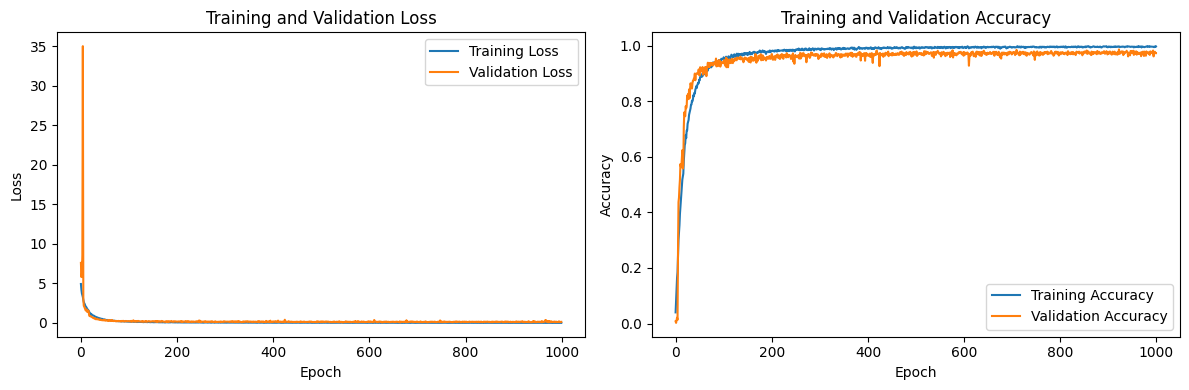

In [16]:
# load the best model weights
model.load_weights('best_model_weights.h5')

# Evaluate the model using validation sets
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation loss: {val_loss}')
print(f'Validation accuracy: {val_accuracy}')

# Evaluate the model using test sets
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

train_loss, train_accuracy = model.evaluate(train_generator)
print(f'Train loss: {train_loss}')
print(f'Train accuracy: {train_accuracy}')

# plot training fighure
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(log_df['epoch'], log_df['loss'], label='Training Loss')
plt.plot(log_df['epoch'], log_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(log_df['epoch'], log_df['accuracy'], label='Training Accuracy')
plt.plot(log_df['epoch'], log_df['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evalueate model using Transfer Learning Data
Random rotate

19/19 [==============================] - 1s 32ms/step
Transfer Accuracy: 0.9818780889621087
Classification Report on transfer data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         1
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         1
           8       0.00      0.00      0.00         1
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         7
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         4
   

c:\ProgramData\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


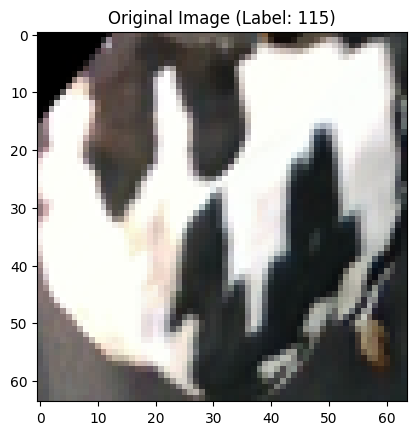

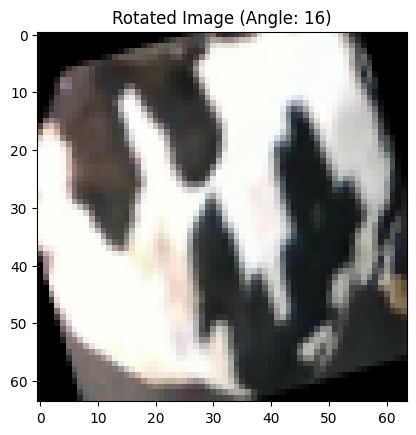

Final input shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 187ms/step
Processed 1/300 images
Processing image 2
Original label: 28, Angle: 9
Original image shape: (64, 64, 3)
Rotated image shape: (64, 64, 3)


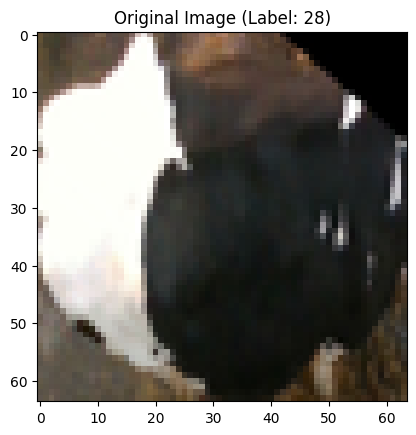

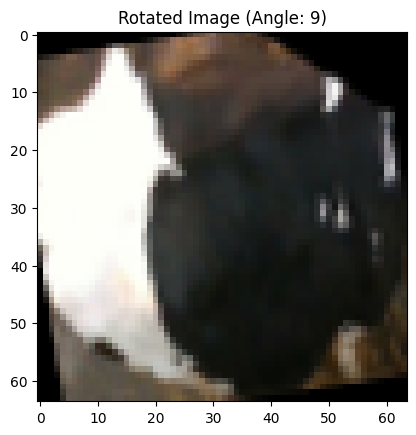

Final input shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 11ms/step
Processing image 3
Original label: 133, Angle: 38
Original image shape: (64, 64, 3)
Rotated image shape: (64, 64, 3)


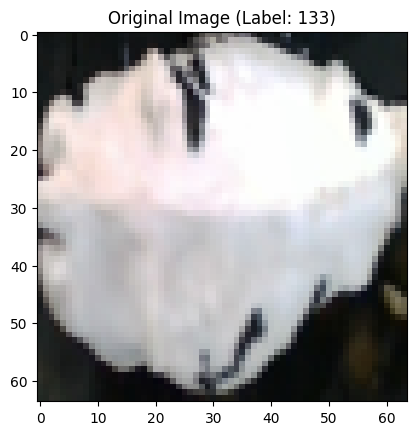

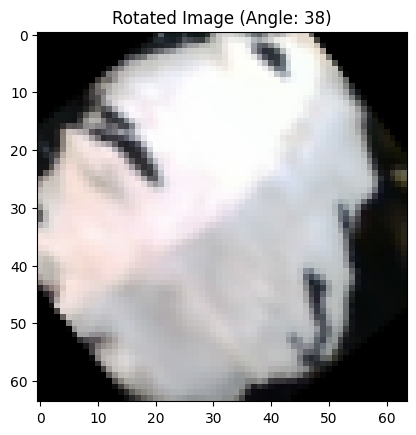

Final input shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 12ms/step
Processing image 4
Original label: 139, Angle: 36
Original image shape: (64, 64, 3)
Rotated image shape: (64, 64, 3)


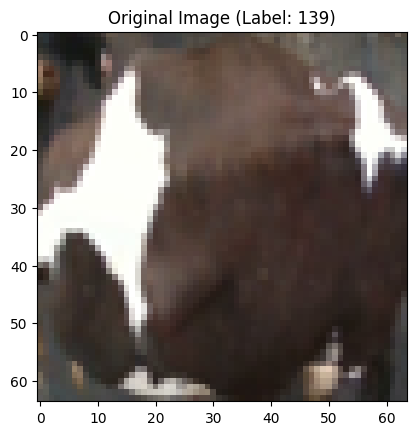

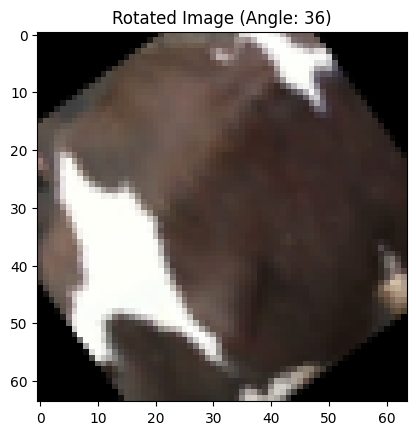

Final input shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 11ms/step
Processing image 5
Original label: 93, Angle: 49
Original image shape: (64, 64, 3)
Rotated image shape: (64, 64, 3)


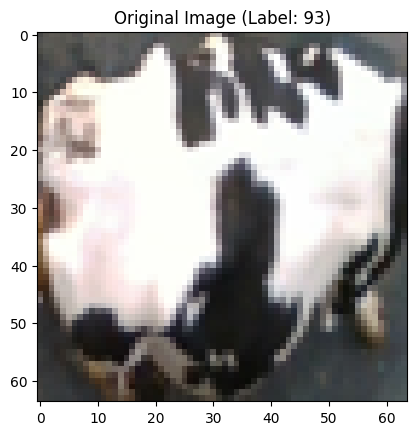

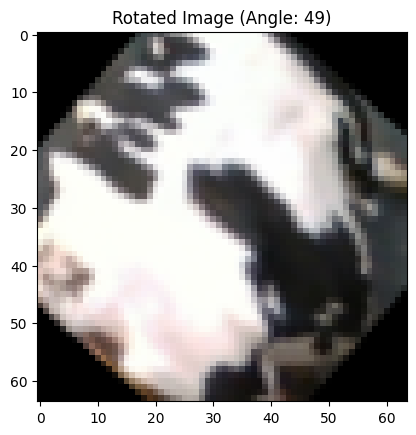

Final input shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 11ms/step
Final input shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 11ms/step
Final input shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 11ms/step
Final input shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 19ms/step
Final input shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 12ms/step
Final input shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 12ms/step
Final input shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 11ms/step
Processed 11/300 images
Final input shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 11ms/step
Final input shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 11ms/step
Final input shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 12ms/step
Final input shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 12ms/step
Final input shape: (1, 64, 64,

In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def display_and_rotate_random_image(images, labels, model, label_encoder, num_samples=100):
    accuracy_list = []

    print(f"Starting processing {num_samples} images")
    print(f"Input images shape: {images.shape}")
    print(f"Model input shape: {model.input_shape}")

    for i in range(num_samples):
        try:
            random_index = np.random.randint(0, len(images))
            image = images[random_index]
            cow_id = label_encoder.inverse_transform([np.argmax(labels[random_index])])[0]

            angle = np.random.randint(-90, 90)

            # Check if the image is single channel
            if len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 1):
                # for single channel image
                center = (image.shape[1] // 2, image.shape[0] // 2)
                rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
                rotated_image = cv2.warpAffine(image, rot_matrix, (image.shape[1], image.shape[0]))
                rotated_image = np.expand_dims(rotated_image, axis=-1)  # 添加通道维度
            else:
                # for RGB image
                center = (image.shape[1] // 2, image.shape[0] // 2)
                rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
                rotated_image = cv2.warpAffine(image, rot_matrix, (image.shape[1], image.shape[0]))

            if i < 5:
                # Processing information
                print(f"Processing image {i+1}")
                print(f"Original label: {cow_id}, Angle: {angle}")
                print(f"Original image shape: {image.shape}")
                print(f"Rotated image shape: {rotated_image.shape}")
                plt.imshow(image.squeeze(), cmap='gray' if len(image.shape) == 2 or image.shape[2] == 1 else None)
                plt.title(f"Original Image (Label: {cow_id})")
                plt.show()

                plt.imshow(rotated_image.squeeze(), cmap='gray' if len(rotated_image.shape) == 2 or rotated_image.shape[2] == 1 else None)
                plt.title(f"Rotated Image (Angle: {angle})")
                plt.show()

            # ensure the input image same with model
            input_shape = model.input_shape[1:]  # get the input shape of model
            if rotated_image.shape != input_shape:
                print(f"Adjusting image shape from {rotated_image.shape} to {input_shape}")
                # Adjust the image to match the model input
                if len(input_shape) == 3 and input_shape[2] == 3 and len(rotated_image.shape) == 2:
                    # If the model expects three channels but the image is a single channel, copy the channel
                    rotated_image = np.stack((rotated_image,)*3, axis=-1)
                elif len(input_shape) == 3 and input_shape[2] == 1 and len(rotated_image.shape) == 3:
                    # If the model expects a single channel but the image is three-channel, convert to grayscale
                    rotated_image = cv2.cvtColor(rotated_image, cv2.COLOR_RGB2GRAY)
                    rotated_image = np.expand_dims(rotated_image, axis=-1)
                
                # Resize to match the model input
                rotated_image = cv2.resize(rotated_image, (input_shape[1], input_shape[0]))
                if len(input_shape) == 3:
                    rotated_image = rotated_image.reshape(input_shape)

            rotated_image = np.expand_dims(rotated_image, axis=0)
            print(f"Final input shape: {rotated_image.shape}")
            predictions = model.predict(rotated_image)
            predicted_label = label_encoder.inverse_transform([np.argmax(predictions)])[0]

            is_correct = (predicted_label == cow_id)
            accuracy_list.append(is_correct)

            if i % 10 == 0:
                print(f"Processed {i+1}/{num_samples} images")

        except Exception as e:
            print(f"Error processing image {i+1}: {str(e)}")

    if accuracy_list:
        total_accuracy = np.mean(accuracy_list)
        print("Total_accuracy:", total_accuracy)
    else:
        print("No images were successfully processed.")



import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
# load transfer learning data
transfer_data_path = 'transfer_learning_data.npz'
transfer_data = np.load(transfer_data_path)
trans_images = transfer_data['transfer_learning_images']
trans_labels = transfer_data['transfer_learning_labels']

# make prediction
y_pred = model.predict(trans_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# decoded label
y_transfer_decoded = np.argmax(trans_labels, axis=1)

# evaluate the model
accuracy = accuracy_score(y_transfer_decoded, y_pred_classes)
report = classification_report(y_transfer_decoded, y_pred_classes)

print(f'Transfer Accuracy: {accuracy}')
print(f'Classification Report on transfer data:\n{report}')

# use transer learning image to evalua the accuracy
display_and_rotate_random_image(trans_images, trans_labels, model, label_encoder, num_samples=300)

# Confusion Matrix

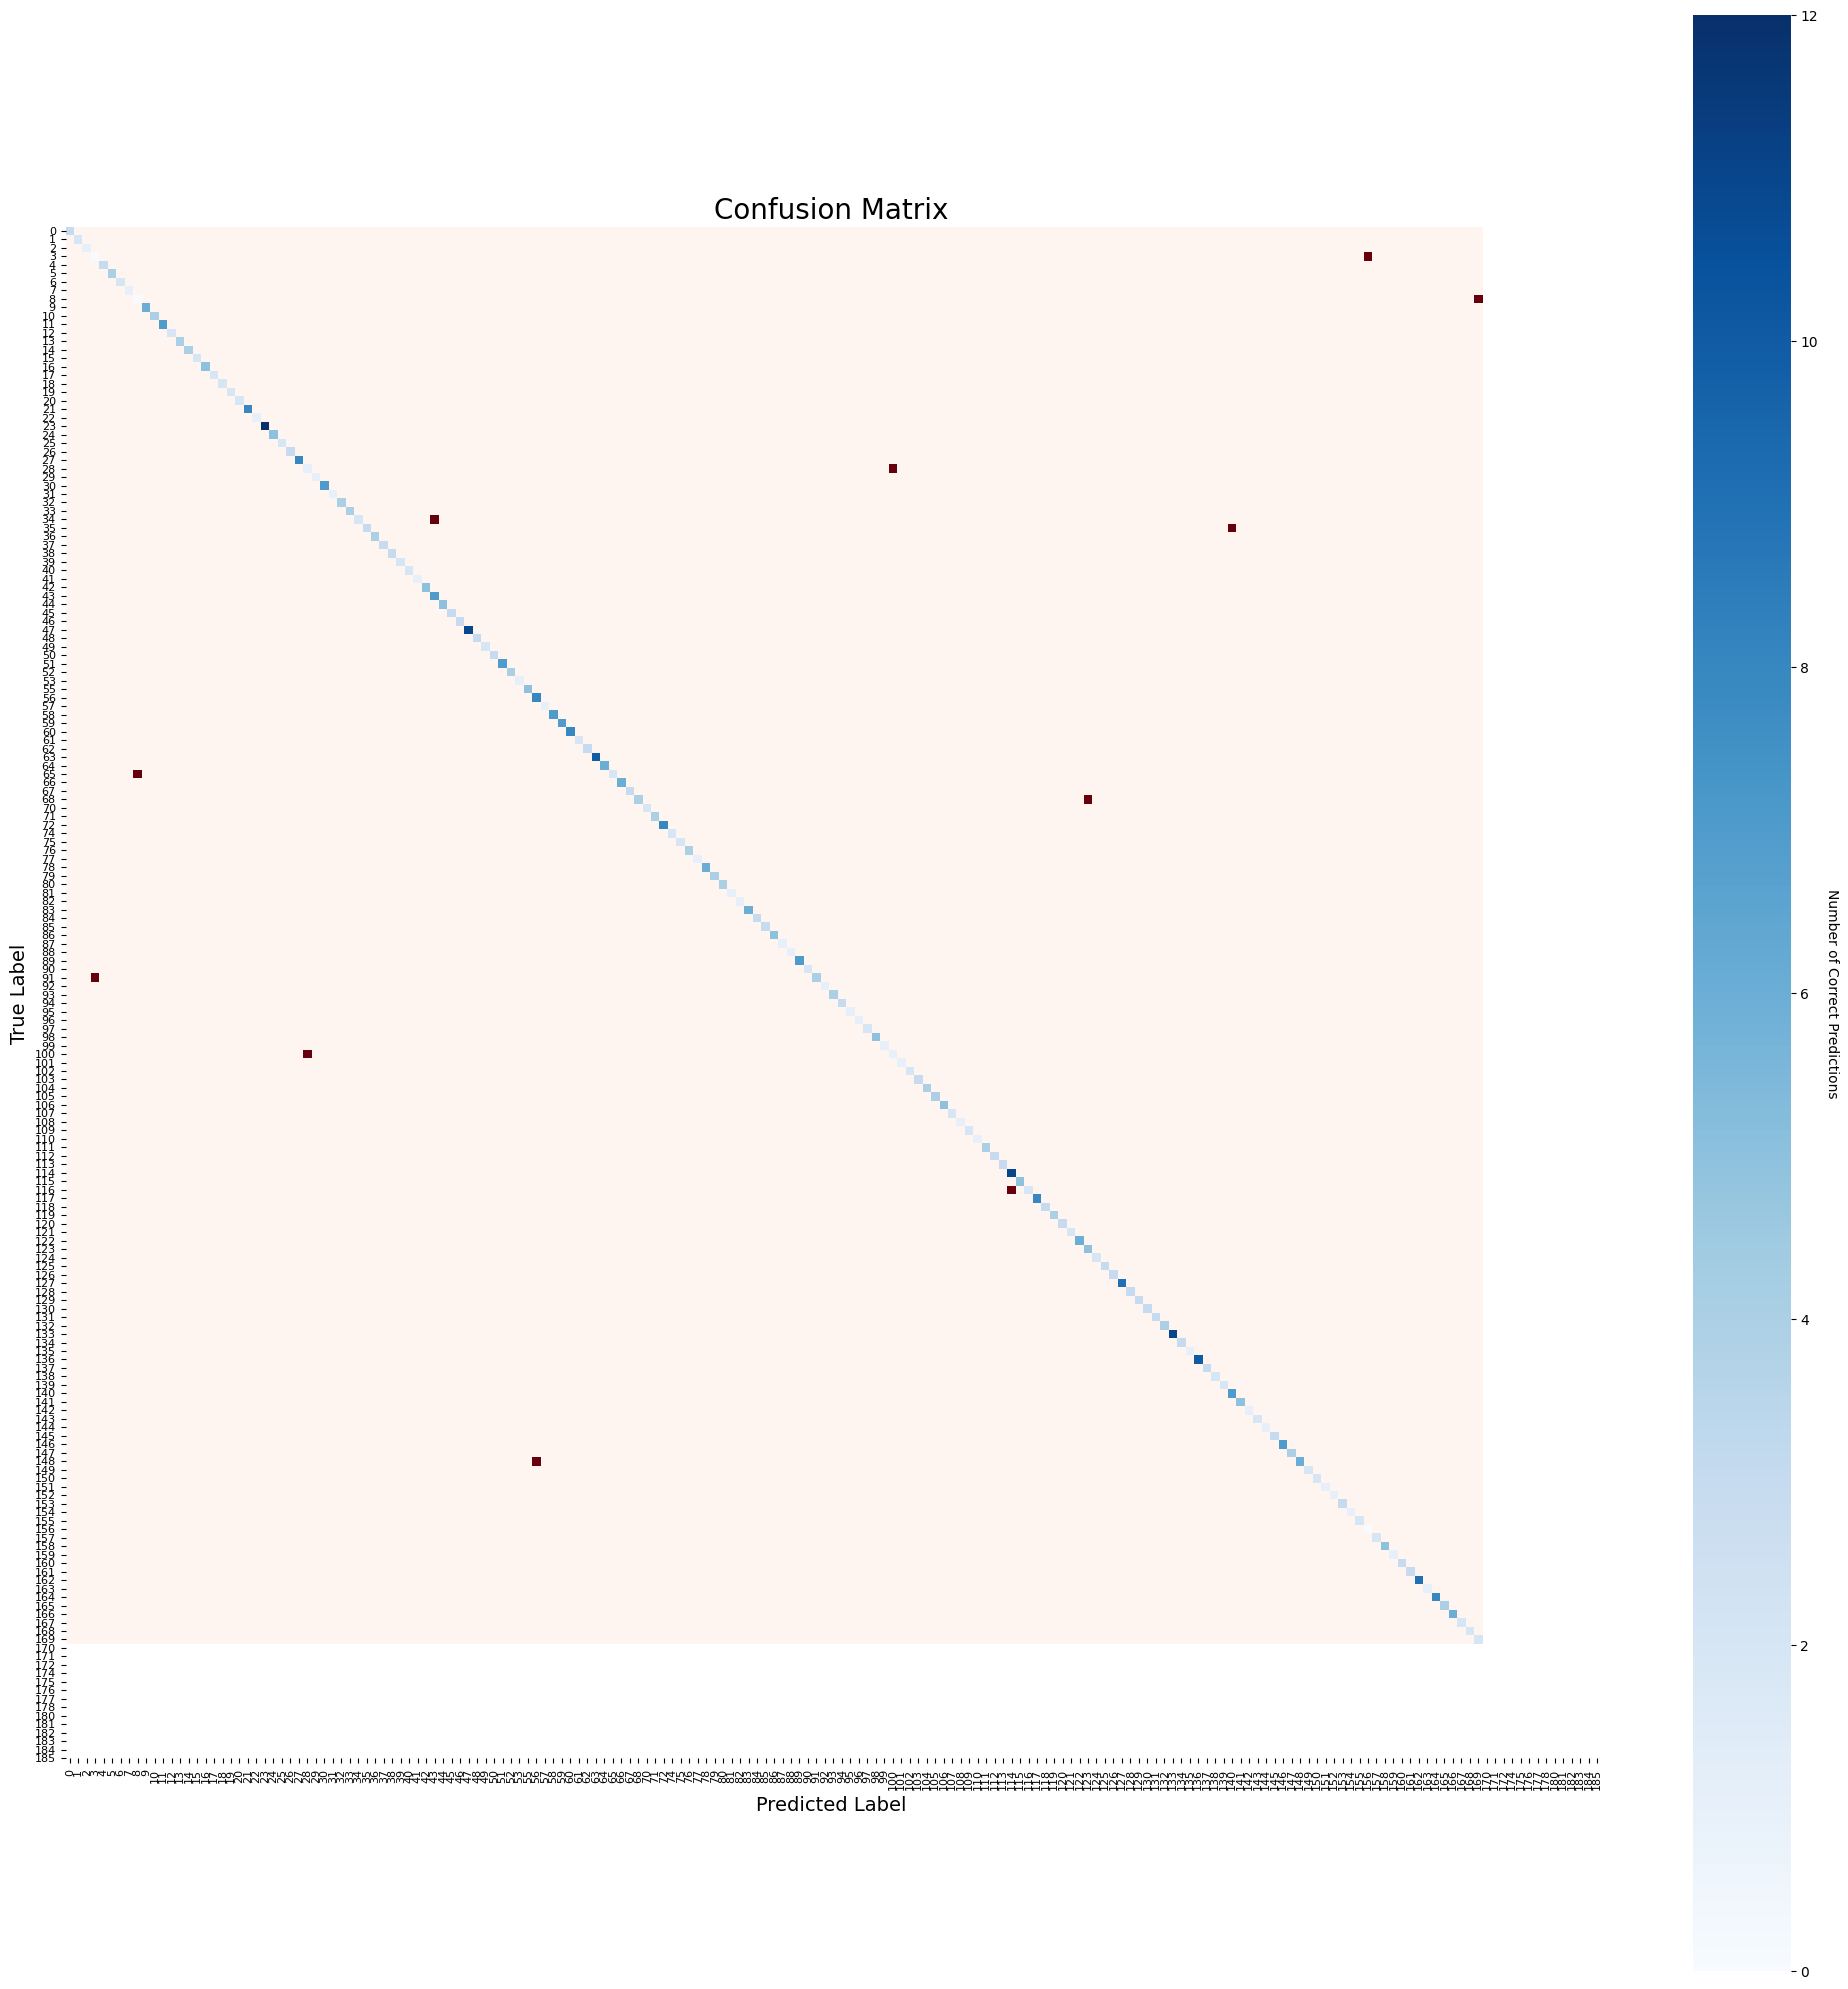

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


def plot_confusion_matrix(y_true, y_pred, label_encoder, figsize=(20, 20)):
    # compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # get category label
    class_names = label_encoder.classes_
    
    # Create a mask with the diagonal False and the others True
    mask = ~np.eye(cm.shape[0], dtype=bool)
    
    # Create a larger graph
    fig, ax = plt.subplots(figsize=figsize)
    
    # Heat map with seaborn (diagonal elements for correct prediction)
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', square=True,
                xticklabels=class_names, yticklabels=class_names,
                mask=mask, ax=ax)
    
    # Heat map with seaborn (non-diagonal elements for in-correct prediction)
    sns.heatmap(cm, annot=False, fmt='d', cmap='Reds', square=True,
                xticklabels=class_names, yticklabels=class_names,
                mask=~mask, cbar=False, ax=ax)
    
    # Set the title and label
    ax.set_title('Confusion Matrix', fontsize=20)
    ax.set_xlabel('Predicted Label', fontsize=14)
    ax.set_ylabel('True Label', fontsize=14)
    
    # Adjust the scale label size
    ax.tick_params(axis='both', which='major', labelsize=8)
    plt.xticks(rotation=90)
    
    # Add color bar
    cbar = ax.collections[0].colorbar
    cbar.set_label('Number of Correct Predictions', rotation=270, labelpad=15)
    
    # Display graphics
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_transfer_decoded, y_pred_classes, label_encoder)

# Error Analysis

In [19]:
def error_analysis(y_true, y_pred, label_encoder):
    errors = y_true != y_pred
    error_indices = np.where(errors)[0]

    error_counts = {}
    for idx in error_indices:
        true_label = label_encoder.inverse_transform([y_true[idx]])[0]
        pred_label = label_encoder.inverse_transform([y_pred[idx]])[0]
        error_pair = (true_label, pred_label)
        error_counts[error_pair] = error_counts.get(error_pair, 0) + 1

    sorted_errors = sorted(error_counts.items(), key=lambda x: x[1], reverse=True)

    print("Top 5 most common misclassifications:")
    for (true_label, pred_label), count in sorted_errors[:5]:
        print(f"True: {true_label}, Predicted: {pred_label}, Count: {count}")

# Execute error analysis
error_analysis(y_transfer_decoded, y_pred_classes, label_encoder)

# Analyze the performance of the model on different categories
class_report = classification_report(y_transfer_decoded, y_pred_classes, output_dict=True)
class_performance = pd.DataFrame(class_report).transpose()
class_performance = class_performance.sort_values(by='f1-score', ascending=False)

print("Top 5 best performing classes:")
print(class_performance.head())

print("\nBottom 15 worst performing classes:")
print(class_performance.tail(15))

Top 5 most common misclassifications:
True: 154, Predicted: 58, Count: 1
True: 71, Predicted: 128, Count: 1
True: 95, Predicted: 3, Count: 1
True: 37, Predicted: 145, Count: 1
True: 67, Predicted: 8, Count: 1
Top 5 best performing classes:
     precision  recall  f1-score  support
0          1.0     1.0       1.0      3.0
117        1.0     1.0       1.0      5.0
109        1.0     1.0       1.0      2.0
110        1.0     1.0       1.0      1.0
111        1.0     1.0       1.0      2.0

Bottom 15 worst performing classes:
     precision    recall  f1-score  support
45    0.875000  1.000000  0.933333      7.0
151   1.000000  0.857143  0.923077      7.0
125   0.833333  1.000000  0.909091      5.0
69    1.000000  0.800000  0.888889      5.0
92    1.000000  0.800000  0.888889      5.0
37    1.000000  0.750000  0.857143      4.0
118   1.000000  0.666667  0.800000      3.0
176   0.666667  1.000000  0.800000      2.0
36    1.000000  0.666667  0.800000      3.0
66    1.000000  0.666667  0.800

c:\ProgramData\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


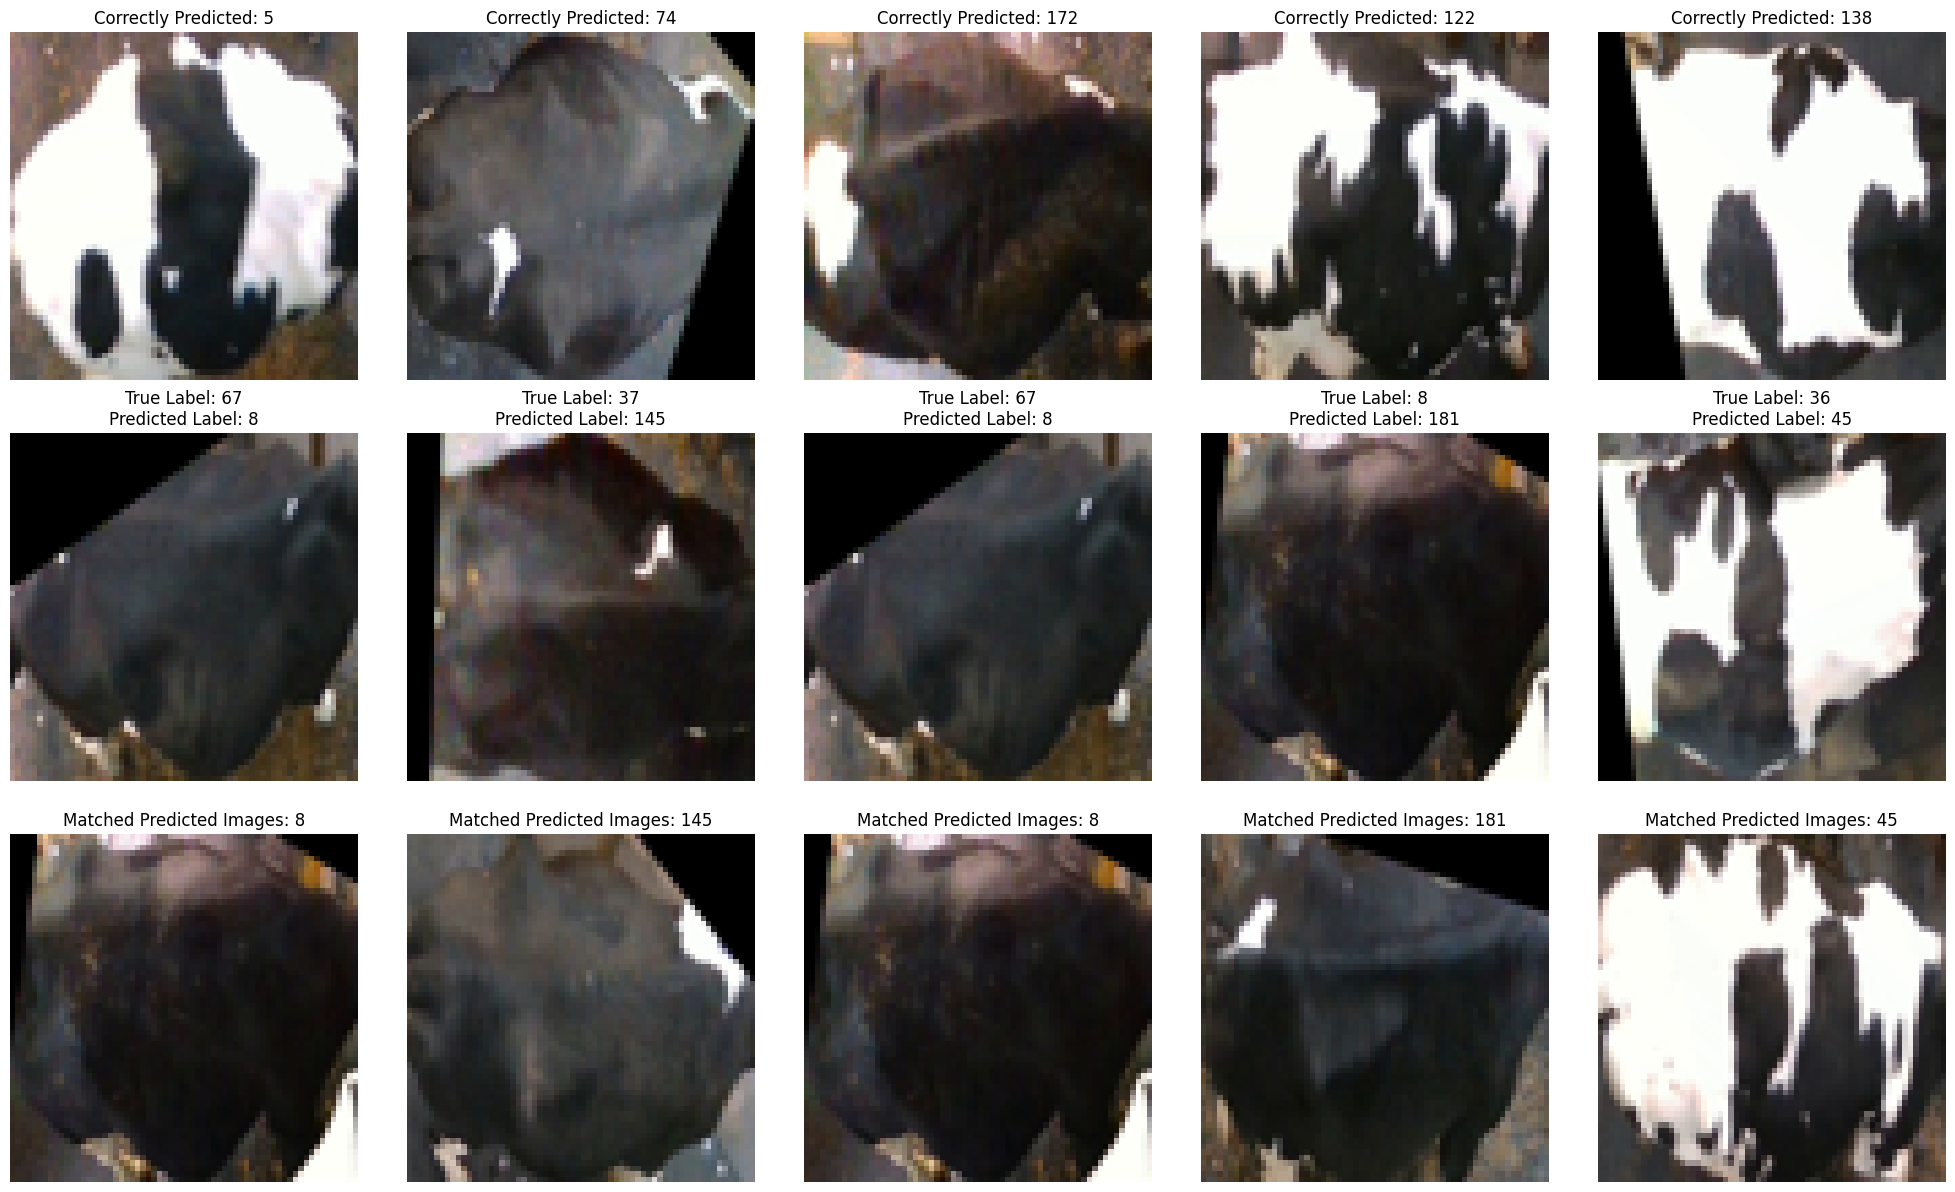

In [22]:
def visualize_samples(images, true_labels, pred_labels, label_encoder, num_samples=5):
    correct_indices = np.where(true_labels == pred_labels)[0]
    incorrect_indices = np.where(true_labels != pred_labels)[0]
    
    fig, axes = plt.subplots(3, num_samples, figsize=(20, 12))  # Increased to 3 rows
    
    for i in range(num_samples):
        # Properly classified samples
        if correct_indices.size > 0:  # Check if there are any correct predictions
            correct_idx = np.random.choice(correct_indices)
            axes[0, i].imshow(images[correct_idx].reshape(64, 64, 3))
            axes[0, i].set_title(f"Correctly Predicted: {label_encoder.inverse_transform([true_labels[correct_idx]])[0]}")
            axes[0, i].axis('off')
        else:
            axes[0, i].set_visible(False)  # Hide axes if no correct predictions
        
        # Misclassifed sample
        if incorrect_indices.size > 0:
            incorrect_idx = np.random.choice(incorrect_indices)
            axes[1, i].imshow(images[incorrect_idx].reshape(64, 64, 3))
            axes[1, i].set_title(f"True Label: {label_encoder.inverse_transform([true_labels[incorrect_idx]])[0]}\nPredicted Label: {label_encoder.inverse_transform([pred_labels[incorrect_idx]])[0]}")
            axes[1, i].axis('off')

            # Find and display samples that are incorrectly predicted
            pred_as_idx = np.where(true_labels == pred_labels[incorrect_idx])[0]  # Find where this prediction was correct
            if pred_as_idx.size > 0:
                matched_idx = np.random.choice(pred_as_idx)
                axes[2, i].imshow(images[matched_idx].reshape(64, 64, 3))
                axes[2, i].set_title(f"Matched Predicted Images: {label_encoder.inverse_transform([true_labels[matched_idx]])[0]}")
                axes[2, i].axis('off')
            else:
                axes[2, i].text(0.5, 0.5, 'No matching\ntrue label found', horizontalalignment='center', verticalalignment='center', transform=axes[2, i].transAxes)
                axes[2, i].axis('off')
        else:
            axes[1, i].set_visible(False)
            axes[2, i].set_visible(False)  # Hide the third row if no incorrect predictions

    plt.tight_layout()
    plt.show()

# Visualize
visualize_samples(trans_images, y_transfer_decoded, y_pred_classes, label_encoder)